## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

we will be working to understand the results of an A/B test run by an e-commerce website and help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# import necesary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#read data set
df=pd.read_csv('ab_data.csv')

In [3]:
#visualize data set
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# data set number of rows
df.shape[0]

294478

In [5]:
# unique values number
df.user_id.nunique()

290584

In [6]:
#proportion of converted users 
df.query('converted==1').shape[0]/df.shape[0]

0.11965919355605512

In [7]:
# number of rows of wrong data 
df[(df.group=='treatment') &
   (df.landing_page=='old_page')].append(df[(df.group=='control') &
                                            (df.landing_page=='new_page')]).shape[0]

3893

In [8]:
# check missing data in each column
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [9]:
#data set of cleaning wrong data
df2=df[(df.group=='treatment') & (df.landing_page=='new_page')].append(df[(df.group=='control') & (df.landing_page=='old_page')])
df2

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
...,...,...,...,...,...
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# check redundancy in user id 's
df2.user_id.nunique()
#it less than our data set rows by one , which means there is one id repeated.

290584

In [12]:
# obtain this user id
df2[df2.user_id.duplicated()==True].user_id

2893    773192
Name: user_id, dtype: int64

In [13]:
# visualize this user id.
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# drop one of the 2 redundant id's by index of one of them.
df2.drop(index=1899,inplace=True)

In [15]:
#check that it's removed
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
# probability of converted users
df2[df2.converted==1].shape[0]/df2.shape[0]

0.11959708724499628

In [17]:
# probability of converted users in control group
real_p_old=df2[(df2.group=='control')&(df2.converted==1)].shape[0]/df2[(df2.group=='control')].shape[0]
real_p_old

0.1203863045004612

In [18]:
# probability of converted users in treatment group
real_p_new=df2[(df2.group=='treatment')&(df2.converted==1)].shape[0]/df2[(df2.group=='treatment')].shape[0]
real_p_new

0.11880806551510564

In [19]:
# probability of users recieving new pages
df2[df2.landing_page=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

**with 2 groups recieving new and old pages are equal in users number, it seems to be the conversion rate of the old page is higher**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<ul>
  <li>

H0:p_old=p_new

</li>
    
  <li>H1:p_new
      !=p_old</li>

</ul> 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [20]:
#  proability of whether to convert to old or new page
p_new=df2[df2['converted']==1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

In [21]:
# under the null hypo, the 2 proabilities(whether to convert to old or new page) are the same
p_old=p_new
p_old

0.11959708724499628

In [22]:
# number of users getting new page
n_new=df2[df2.landing_page=='new_page'].shape[0]
n_new

145310

In [23]:
# number of users getting old page
n_old=df2[df2.landing_page=='old_page'].shape[0]
n_old

145274

In [24]:
#random sampling of conversion to new page
new_page_converted=np.random.choice([0,1],size=n_new,p=[p_new,1-p_new])
new_page_converted

array([1, 1, 1, ..., 0, 1, 1])

In [25]:
#random sampling of conversion to old page
old_page_converted=np.random.choice([0,1],size=n_old,p=[p_old,1-p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
# minusing the 2 propabilities of conversion to new/old page
new_page_converted.mean()-old_page_converted.mean()


5.026271031516316e-05

In [27]:
# random sampling of the difference between 2 probabilities
#getting 10000 samples
#each sample contain the difference probabilites between conversion to new/old pages.
p_diffs=[]
for i in range(10000):
    pp=(np.random.choice([0,1],size=n_new,p=[p_new,1-p_new])).mean()
    p=(np.random.choice([0,1],size=n_old,p=[p_old,1-p_old])).mean()
    p_diffs.append(pp-p)
    

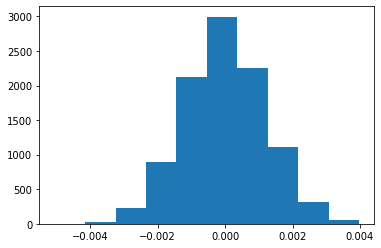

In [28]:
#plotting the differece probabilities result in a bell shaped graph
#According to the central limit theorem:
####while had sampling distribution of sample mean and each sample size> 30
####hence we have a normal ditribution
import matplotlib.pyplot as plt
plt.hist(p_diffs);

In [52]:
# claculating the p_value in 2 sided test
p_diffs=np.array(p_diffs)
a_diffs=real_p_new-real_p_old
tt=p_diffs[p_diffs>a_diffs].mean()
t=(p_diffs.mean() + (p_diffs.mean() - a_diffs) > p_diffs).mean()
p_value=t+tt
p_value

0.901015244428579

**P_value** -->
when p_value is <0.05 then the probability of the null hypotheses to be true is very low, hence we reject H0.
here is > 0.05 then we accept the H0 and hence there is no difference between the 2 pages.



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2[(df2.group=='control')&(df2.converted==1)].shape[0]
convert_new = df2[(df2.group=='treatment')&(df2.converted==1)].shape[0]
n_old = df2[df2.landing_page=='old_page'].shape[0]
n_new = df2[df2.landing_page=='new_page'].shape[0]


In [55]:
#calculate z score
z_score,p_value=sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='two-sided')
z_score,1-p_value

(1.3109241984234394, 0.810116625518049)

**Z score is between -1.96 and +1.96,and p-value> 0.05,we don't reject H0, hence the 2 pages result in no change and they have the same effect**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we use type of regression of

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
# add intercept and dummy variables
df2['intercept']=1
df2[['ab_page','temp']]=pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,temp
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0


In [33]:
# drop unnecessary columns
df2.drop(['landing_page','temp'],inplace=True,axis=1)

In [34]:
#visualize data
df2.head()

,user_id,timestamp,group,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,1,1,1


In [35]:
df2.tail()

,user_id,timestamp,group,converted,intercept,ab_page
294471,718310,2017-01-21 22:44:20.378320,control,0,1,0
294473,751197,2017-01-03 22:28:38.630509,control,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,0,1,0


In [36]:
#initialize model
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
fitted=model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [37]:
#regression summary
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:45:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

<ul>
  <li>p value of 0.190 which is different but little closer to the p_value we've obtained form hypotheses test</li>
  <li>It differs as there is difference between hypotheses in both tests</li>
  <li>the null hypotheses in logistic regression : there is no relationship between dependent and independent       variable.</li>
  <li>the alternative hypotheses: there is relationship between dependent and independent variable.</li>
  <li>in partII the null hypotheses is probabilities for converting for both pages are the same</li>


</ul> 



**Adding more factors can result in more accurate model but these more data might has no correlation with our dependent variable in case of time of recieving each page or data might be incorrect.**

In [38]:
#read the counties and merge beween it and our data set
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
#obtain unique countries
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
### Create the necessary dummy variables
df_new[['UK', 'US', 'CA']]=pd.get_dummies(df_new['country'])
df_new.drop(columns=['country','CA'],inplace=True)

In [40]:
#visualize after adding dumming variables
df_new.head()

,timestamp,group,converted,intercept,ab_page,UK,US
user_id,,,,,,,
834778,2017-01-14 23:08:43.304998,control,0,1,0,0,1
928468,2017-01-23 14:44:16.387854,treatment,0,1,1,0,0
822059,2017-01-16 14:04:14.719771,treatment,1,1,1,0,1
711597,2017-01-22 03:14:24.763511,control,0,1,0,0,1
710616,2017-01-16 13:14:44.000513,treatment,0,1,1,0,1


In [41]:
### Fit Your Linear Model And Obtain the Results
mod=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK', 'US']])
f=mod.fit()
f.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:45:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**providing high p_value for country,countries has insignificant effect on conversion and we still reject H0 and hence, there is no differences between the 2 pages**

In [42]:
df_new['UK_page'] = df_new['UK']*df_new['ab_page']
df_new['US_page'] = df_new['US']*df_new['ab_page']
lo_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK_page', 'US_page']])
final = lo_mod.fit()
final.summary()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:               2.364e-05
Time:                        14:45:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
UK_page       -0.0752      0.038     -1.997      0.046      -0.149      -0.001
US_page        0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""


***the p_value of UK has  statistically significant effect as (p = 0.046; p < 0.05).***

